# Fraudulent Credit Card Spending Project:


### Objectives

This project is intended to analyze a number of consumer spending behavior to detect possible fraudulent actions in credit card spending. The project uses machine learning model (i.e. random forest model) to analyze a number of consumer spending behavior such as purhashing time, purchasing amount, consumer age, sex, IP address, etc. The model is able to predict fraudulent credit transaction with a prediction accuracy of 95% and with a AUC of 83% in the tested scenerios

In [3]:
# import and set environment
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report,roc_auc_score

### Step1: Load data and add country to the data

In [1]:
data = pd.read_csv(r'Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
address2country = pd.read_csv(r'IpAddress_to_Country.csv')

NameError: name 'pd' is not defined

We want to merge the two data source together; therefore, we define new check_country function as below:

In [33]:
def check_country(ip):
    try:
        return address2country[(ip>address2country['lower_bound_ip_address'])&
                               (ip<address2country['upper_bound_ip_address'])]['country'].values[0]
    except:
        return None


data['country'] = data['ip_address'].apply(lambda x: check_country(x))

In [34]:
data['country'].value_counts().head(10)

United States        58049
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Italy                 1944
Name: country, dtype: int64

### Comment
The data is showing that the top 3 country that has credit card transaction is: US, China and Japan. They all seem to be reasonable.

### Step2: Feature Engineering

There are a number of features we could use to help pattern recognition and identify potential abuse in credit card purchasing behavior:
1. It is very suspicious for a user signup and then immediately purchase; thus, we could use the time interval after signup
2. Also, we could study how many devices that are using the same credit card; thus, because we are studying user's first transaction, the higher the device num, the higher the possibility of fraud
3. In addition, we could use ip address to study the fraud behaviour; thus, because we are studying user's first transaction, the higher the ip address being used, the higher the possibility of fraud
4. I would also use the users from a particular country. For example, if we find a purchase from some very undeveloped country where credit card is not popular transaction at all, it is very suspicious.

In [20]:
# it is very suspicious for a user signup and then immediately purchase
data['interval_after_signup'] = (data.purchase_time - data.signup_time).dt.total_seconds()

In [21]:
# how many times a device is shared
n_dev_shared = data.device_id.value_counts()
data['n_dev_shared'] = data.device_id.map(n_dev_shared)

In [22]:
# the num of ip address being used
n_ip_shared = data.ip_address.value_counts()
# the more a ip is shared, the more suspicous
data['n_ip_shared'] = data.ip_address.map(n_ip_shared)

In [23]:
# how many users are from the same country
n_country_shared = data.country.value_counts()

# the less visit from a country, the more suspicious
data['n_country_shared'] = data.country.map(n_country_shared)

In [24]:
data['is_male'] = (data.sex == 'M').astype(int)

In [25]:
data_use=data.dropna()[[ u'purchase_value', u'source', u'browser', u'age', u'interval_after_signup', u'n_dev_shared',
       u'n_ip_shared', u'n_country_shared', u'is_male']]

data_use = pd.get_dummies(data_use,columns=['source','browser'])
fraud = data.dropna()['class']
data_use.head()


,purchase_value,age,interval_after_signup,n_dev_shared,n_ip_shared,n_country_shared,is_male,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,34,39,4506682.0,1,1,7306.0,1,0,0,1,1,0,0,0,0
1,16,53,17944.0,1,1,58049.0,0,1,0,0,1,0,0,0,0
2,15,53,1.0,12,12,58049.0,1,0,0,1,0,0,0,1,0
4,39,45,4361461.0,1,1,58049.0,1,1,0,0,0,0,0,0,1
5,42,18,4240931.0,1,1,2975.0,1,1,0,0,1,0,0,0,0


### Step3: Data Visualization

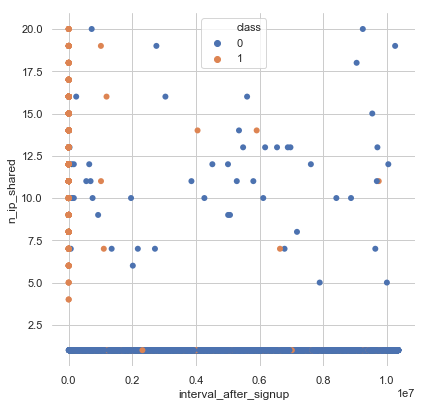

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="interval_after_signup", y="n_ip_shared",
                hue="class",
                sizes=(1, 8), linewidth=0,
                data=data.iloc[:10000], ax=ax)

### comments

It shows that the lower the interval after signup, the more likely for fraud. It also shows that the higher the n_ip_shared, it is possible for higher fraud rate as well.


### Step4:train models

I am using random forest model to model this problem because it is a classical classification problem

C:\Users\junjq\Anaconda2\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Training Random Forest...
The classifier accuracy score is 0.95
The 3-fold cross-validation accuracy score for this classifier is 0.95


([<matplotlib.axis.YTick at 0x10c01ac8>,
 <a list of 15 Text yticklabel objects>)

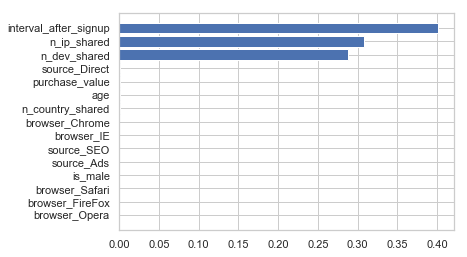

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

x_train, x_test, y_train, y_test = train_test_split(data_use, fraud, 
                                                    test_size=0.20, random_state=0)

n_folds = 3

kf = KFold(n_splits=n_folds)
kf = kf.get_n_splits(x_train)

print ('Training Random Forest...')

clf_rf = RandomForestClassifier(n_estimators=100,max_depth=5) 
clf_rf = clf_rf.fit( x_train, y_train )
classifier_score = clf_rf.score(x_test, y_test)
print ('The classifier accuracy score is {:.2f}'.format(classifier_score))
# Get average of 3-fold cross-validation score 
score = cross_val_score(clf_rf, x_test, y_test, cv=kf)
print ('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(n_folds, score.mean()))

feature_imp = clf_rf.feature_importances_
feature_imp = pd.Series(feature_imp,
                       index = data_use.columns).sort_values()
plt.barh(range(len(feature_imp)), feature_imp.values, align='center')
plt.yticks(range(len(feature_imp)), feature_imp.index)

The classifier accuracy score is 0.95
The 3-fold cross-validation accuracy score for this classifier is 0.95


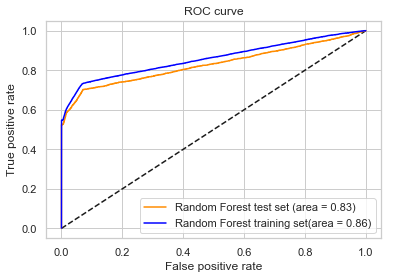

In [29]:
y_test_predicted = clf_rf.predict_proba(x_test)[:, 1]
false_positive, true_positive, _ = roc_curve(y_test, y_test_predicted)
auc = roc_auc_score(y_test, y_test_predicted)

y_train_predicted = clf_rf.predict_proba(x_train)[:, 1]
false_positive2, true_positive2, _ = roc_curve(y_train, y_train_predicted)
auc2 = roc_auc_score(y_train, y_train_predicted)

print ('The classifier accuracy score is {:.2f}'.format(classifier_score))
print ('The {}-fold cross-validation accuracy score for this classifier is {:.2f}'.format(n_folds, score.mean()))
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive, true_positive, color='darkorange', label='Random Forest test set (area = %0.2f)' % auc)
plt.plot(false_positive2, true_positive2, color='blue', label='Random Forest training set(area = %0.2f)' % auc2)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve' )
plt.legend(loc='best')
plt.show()

I am able to yield a 95% accuracy in predicting the fraudulent credit card behaviour. The most relevant predicting features are: interval after sign up, num of ip address shared and num of device shared

### Conclusion
In conclusion, the above model uses machine learning model (i.e. random forest model) to analyze consumer spending behavior. The model is able to predict fraudulent credit transaction with a prediction accuracy of 95% and with a AUC of 83% in the tested scenerios